<a href="https://colab.research.google.com/github/ttezy/Time-Sequence-Analysis/blob/main/LSTM_Multivariate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Step 1: Load data**
## **You may need to upload pollution.csv to /content/pollution.csv**

## **Import libs**

In [324]:
from matplotlib import pyplot as plt
import numpy as np

import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from numpy import concatenate
from math import sqrt

## **Load dataset**

In [325]:
df=pd.read_csv('pollution.csv',header=0, index_col=0)
df

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-01 00:00:00,0.0,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,0.0,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,0.0,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,0.0,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,0.0,-20,-12.0,1018.0,NW,12.97,0,0
...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,NW,231.97,0,0
2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,NW,237.78,0,0
2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,NW,242.70,0,0


## **Visualize data**

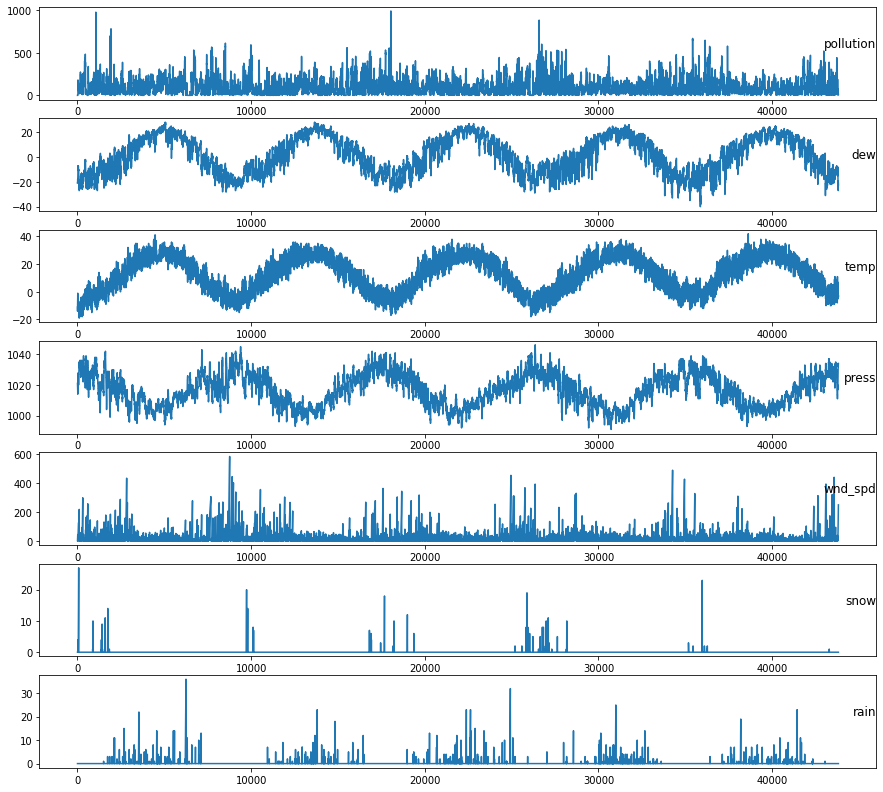

In [326]:
values = df.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
plt.figure(figsize = (15, 14))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(df.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

# **Step 2: Prepare for model**

## **Encode wind direction**

In [327]:
# integer encode direction
encoder = LabelEncoder()
values[:, 4] = encoder.fit_transform(values[:, 4])
# ensure all data is float
values = values.astype('float32')

df['wnd_dir'] = values[:, 4]

df.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-01 00:00:00,0.0,-21,-11.0,1021.0,1.0,1.79,0,0
2010-01-01 01:00:00,0.0,-21,-12.0,1020.0,1.0,4.92,0,0
2010-01-01 02:00:00,0.0,-21,-11.0,1019.0,1.0,6.71,0,0
2010-01-01 03:00:00,0.0,-21,-14.0,1019.0,1.0,9.84,0,0
2010-01-01 04:00:00,0.0,-20,-12.0,1018.0,1.0,12.97,0,0


## **Normalize data values between 0 and 1**

In [328]:
values = df.values
y_true = values[int(len(values) * 0.9):, 0]

# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

print(scaled)

[[0.         0.2794118  0.13114753 ... 0.00229001 0.         0.        ]
 [0.         0.2794118  0.1147541  ... 0.00763907 0.         0.        ]
 [0.         0.2794118  0.13114753 ... 0.01069811 0.         0.        ]
 ...
 [0.01006036 0.2647059  0.26229507 ... 0.41399646 0.         0.        ]
 [0.00804829 0.2647059  0.24590163 ... 0.4208665  0.         0.        ]
 [0.01207243 0.2794118  0.26229507 ... 0.42621556 0.         0.        ]]


## **Reframe dataset for supervised learning**

In [329]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i)[0])
        if i == 0:
            names += ['var1(t)' ]
        else:
            names += [('var1(t+%d)' % (i))]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [330]:
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

# drop columns we don't want to predict
# reframed.drop(reframed.columns[[9, 10, 11, 12, 13, 14, 15]], axis=1, inplace=True)

print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  ...  var7(t-1)  var8(t-1)  var1(t)
1        0.0   0.279412   0.131148  ...        0.0        0.0      0.0
2        0.0   0.279412   0.114754  ...        0.0        0.0      0.0
3        0.0   0.279412   0.131148  ...        0.0        0.0      0.0
4        0.0   0.279412   0.081967  ...        0.0        0.0      0.0
5        0.0   0.294118   0.114754  ...        0.0        0.0      0.0

[5 rows x 9 columns]


## **Split training and testing data**

In [331]:
# split into train and test sets
values = reframed.values

# use first 90% data to train
# n_train_hours = 365 * 24
n_train_hours = int(len(values) * 0.9)
print(n_train_hours)
train = values[:n_train_hours]
test = values[n_train_hours:]

# split into input and output (var(t-1), var1(t))
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print("train_X shape: ", train_X.shape, " train_y shape: ", train_y.shape,
      "\ntest_X shape: ", test_X.shape, " test_y shape: ", test_y.shape)

39440
train_X shape:  (39440, 1, 8)  train_y shape:  (39440,) 
test_X shape:  (4383, 1, 8)  test_y shape:  (4383,)


# **Step 3: Train LSTM(Long Short-term Memory) model**

## **Design network**

In [332]:
# model = Sequential()
# model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
# model.add(Dense(1))
# model.compile(loss='mae', optimizer='adam')

## **Fit model**

In [333]:
# epochs = 50 # modify here to choose training epoches
# history = model.fit(train_X, train_y, epochs=epochs, batch_size=72, validation_data=(test_X, test_y), verbose=2,
#                     shuffle=False)

## **Show the training loss and test loss**

In [334]:
# # plot history
# plt.figure(figsize=(10,5))
# plt.plot(history.history['loss'], label='train loss')
# plt.plot(history.history['val_loss'], label='test loss')
# plt.title("LSTM epochs: " + str(epochs))
# plt.legend()
# plt.show()

# **Step 4: Implement Data Forecasting**

In [335]:
# futureStep = 1
# yhat = model.predict(test_X, steps=futureStep)
# test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# # invert scaling for forecast
# inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
# inv_yhat = scaler.inverse_transform(inv_yhat)
# inv_yhat = inv_yhat[:, 0]
# # invert scaling for actual
# test_y = test_y.reshape((len(test_y), 1))
# inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
# inv_y = scaler.inverse_transform(inv_y)
# inv_y = inv_y[:, 0]
# # calculate RMSE
# rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
# print('Test RMSE: %.3f' % rmse)

# plt.figure(figsize=(15, 8))
# plt.plot(inv_y[:200], label='Ground Truth')
# plt.plot(inv_yhat[:200], label='Prediction')
# plt.title("LSTM epochs: " + str(epochs))
# plt.legend()
# plt.show()

# **Step 5: Test forecasting ability for more future time**

In [336]:
pastStep = 24
futureStep = 5

# frame as supervised learning
reframed = series_to_supervised(scaled, pastStep, futureStep)

print(reframed)

       var1(t-24)  var2(t-24)  var3(t-24)  ...  var1(t+2)  var1(t+3)  var1(t+4)
24       0.000000    0.279412    0.131148  ...   0.159960   0.182093   0.138833
25       0.000000    0.279412    0.114754  ...   0.182093   0.138833   0.109658
26       0.000000    0.279412    0.131148  ...   0.138833   0.109658   0.105634
27       0.000000    0.279412    0.081967  ...   0.109658   0.105634   0.124748
28       0.000000    0.294118    0.114754  ...   0.105634   0.124748   0.120724
...           ...         ...         ...  ...        ...        ...        ...
43815    0.055332    0.382353    0.409836  ...   0.009054   0.010060   0.008048
43816    0.060362    0.382353    0.409836  ...   0.010060   0.008048   0.010060
43817    0.063380    0.382353    0.393443  ...   0.008048   0.010060   0.010060
43818    0.079477    0.397059    0.344262  ...   0.010060   0.010060   0.008048
43819    0.035211    0.470588    0.409836  ...   0.010060   0.008048   0.012072

[43796 rows x 197 columns]


In [337]:
# split into train and test sets
values = reframed.values

# use first 90% data to train
n_train_hours = int(len(values) * 0.9)
train = values[:n_train_hours]
test = values[n_train_hours:]

print("train shape: ", train.shape, "test shape: ", test.shape)

# split into input and output (var(t-1), var1(t))
train_X, train_y = train[:, :-futureStep], train[:, -futureStep:]
test_X, test_y = test[:, :-futureStep:], test[:, -futureStep:]

# reshape input to be 3D [samples, timesteps, features]
train_X_reshape = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X_reshape = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print("train_X_reshape shape: ", train_X_reshape.shape, " train_y shape: ", train_y.shape,
      "\ntest_X_reshape shape: ", test_X_reshape.shape, " test_y shape: ", test_y.shape)

train shape:  (39416, 197) test shape:  (4380, 197)
train_X_reshape shape:  (39416, 1, 192)  train_y shape:  (39416, 5) 
test_X_reshape shape:  (4380, 1, 192)  test_y shape:  (4380, 5)


In [338]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X_reshape.shape[1], train_X_reshape.shape[2])))
model.add(Dense(futureStep))
model.compile(loss='mae', optimizer='adam')

In [339]:
epochs = 50 # modify here to choose training epoches
history = model.fit(train_X_reshape, train_y, epochs=epochs, batch_size=72, validation_data=(test_X_reshape, test_y), verbose=2,
                    shuffle=False)

Epoch 1/50
548/548 - 5s - loss: 0.0425 - val_loss: 0.0322
Epoch 2/50
548/548 - 2s - loss: 0.0339 - val_loss: 0.0306
Epoch 3/50
548/548 - 2s - loss: 0.0319 - val_loss: 0.0306
Epoch 4/50
548/548 - 2s - loss: 0.0306 - val_loss: 0.0297
Epoch 5/50
548/548 - 2s - loss: 0.0299 - val_loss: 0.0294
Epoch 6/50
548/548 - 2s - loss: 0.0294 - val_loss: 0.0306
Epoch 7/50
548/548 - 2s - loss: 0.0289 - val_loss: 0.0293
Epoch 8/50
548/548 - 1s - loss: 0.0286 - val_loss: 0.0283
Epoch 9/50
548/548 - 2s - loss: 0.0284 - val_loss: 0.0272
Epoch 10/50
548/548 - 2s - loss: 0.0282 - val_loss: 0.0269
Epoch 11/50
548/548 - 2s - loss: 0.0280 - val_loss: 0.0261
Epoch 12/50
548/548 - 2s - loss: 0.0278 - val_loss: 0.0258
Epoch 13/50
548/548 - 2s - loss: 0.0277 - val_loss: 0.0256
Epoch 14/50
548/548 - 1s - loss: 0.0275 - val_loss: 0.0256
Epoch 15/50
548/548 - 2s - loss: 0.0273 - val_loss: 0.0254
Epoch 16/50
548/548 - 2s - loss: 0.0271 - val_loss: 0.0252
Epoch 17/50
548/548 - 2s - loss: 0.0270 - val_loss: 0.0250
Epoch 

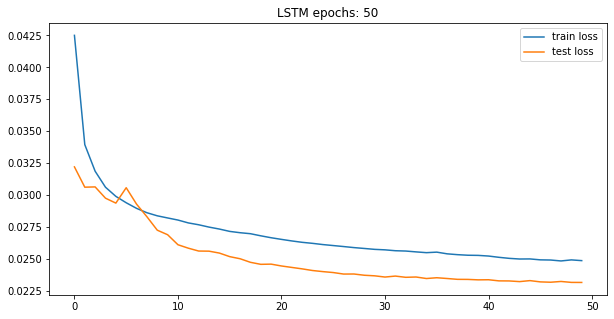

In [340]:
# plot history
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='test loss')
plt.title("LSTM epochs: " + str(epochs))
plt.legend()
plt.show()

In [341]:
result = model.predict(test_X_reshape)


prediction = np.array([])
for i in range(0, len(test_X), futureStep):
  prediction = np.append(prediction, result[i])
prediction = prediction[:len(test_X)]
y_true = y_true[:len(test_X)]

prediction = prediction.reshape((len(prediction), 1))
inv_pred = concatenate((prediction, test_X[:, 1:8]), axis=1)

print("pred shape: ", pred.shape)
print("prediction: ", prediction.shape)
print("test_X shape: ", test_X.shape)
print("test_X[:, 1:8] shape: ", test_X[:, 1:8].shape)
print("inv_pred shape: ", inv_pred.shape)

pred shape:  (4380, 5)
prediction:  (4380, 1)
test_X shape:  (4380, 192)
test_X[:, 1:8] shape:  (4380, 7)
inv_pred shape:  (4380, 8)


In [342]:
inv_pred = scaler.inverse_transform(inv_pred)[:, 0]

In [343]:
print(y_true.shape)

(4380,)


Test RMSE: 45.305


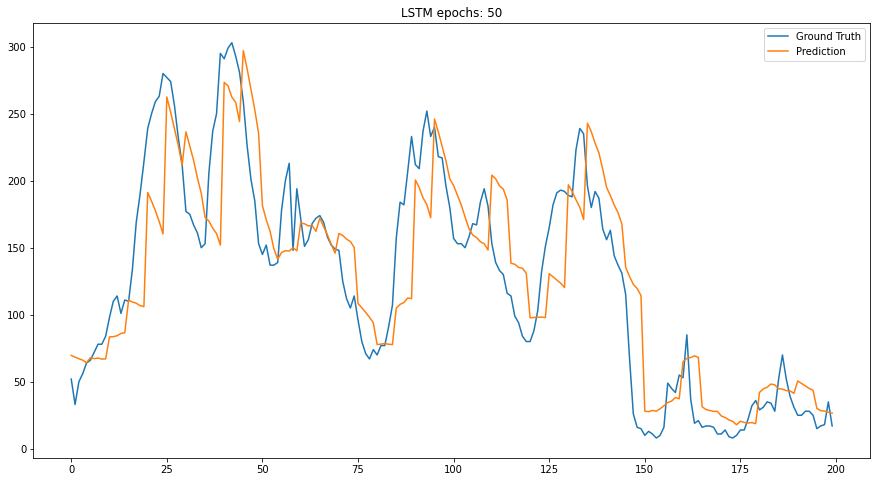

In [345]:
# calculate RMSE
rmse = sqrt(mean_squared_error(y_true, inv_pred))
print('Test RMSE: %.3f' % rmse)

plt.figure(figsize=(15, 8))
plt.plot(y_true[:200], label='Ground Truth')
plt.plot(inv_pred[:200], label='Prediction')
plt.title("LSTM epochs: " + str(epochs))
plt.legend()
plt.show()